# ASTR 596 Fall 2024 - Surface photometry lab (50 Points)

In this lab we will be performing surface photometry of four nearby galaxies, including ellipticals and spirals.  

This lab will be done via a mixture of python commands using the photutils aperture photometry package (https://photutils.readthedocs.io/en/stable/aperture.html) and the photutils isophote fitting package (https://photutils.readthedocs.io/en/stable/isophote.html).  We will also be using imexam and ds9.

In this lab you will learn how to do the following things:
* estimate the background for an image and subtract it;
* estimate initial guesses for input parameters to an isophotal fitting code using ds9;
* fit elliptical isophotes;
* use photometry within these isophotes to measure the radial profile of various parameters;
* compute the radius within which half the total light is contained.  This is called the effective radius.

<i>Note: Enter in all code to the problems in the provided notebook cells. Questions to answer will be <b>bolded</b>.</i>  

All your answers should be entered in this notebook. Each student will need to hand in their own notebook by uploading it to GitHub following the instructions.

In the code places where you will need to put something or write your own code are specified by `#***************`  You will not get points for doing this unless explicitly noted.  Some of these things are just to make sure you are setting up your paths correctly.

**Due on <font color='red'>12/2 at Noon</font>** to be handed into the "Surface Photometry" assignment in <font color='red'>Module 8</font>.

You will need to download the raw data.  You can access it at <ul><a href=https://www.dropbox.com/t/3my6A650iw8hB85l> this dropbox link </a></ul>.  There are four galaxy images.  You will need to measure something from all of them.  The galaxies are:
* NGC 3982
* NGC 5198
* NGC 5985
* PCG 0997820

You should have a directory on your computer called `~/ASTR596/Data`.  You shoudl put the data there.

In [1]:
#import 
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from astropy.io import fits
import glob
import os
from scipy.stats import scoreatpercentile
import astropy.units as u
from scipy import stats

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import colors


from astropy.nddata import CCDData
#from ccdproc import ImageFileCollection, Combiner, combine
from ccdproc import wcs_project

### Some functions to display the images

In [2]:
def imdisplay(image, v1perc=10, v2perc=95, logscale=True):
    '''
    display an image 
    OPTIONAL KEYWORD PARAMETERS
    v1perc: one end of the colormap assigned to the v1perc percent lowest flux 
    v2perc: the other end of the colormap assigned to the v2perc percent highest flux    
    '''
    fig,ax = plt.subplots(figsize=(6,6))
    # make sure image is an np array
    nimage = np.array(image)
    # determine the pixel values at the 10th and 95th percentile
    v1 = scoreatpercentile(nimage,v1perc)
    v2 = scoreatpercentile(nimage,v2perc)
    # display using imshow
    #
    # you can play with alternate cmaps in the function below, such as "viridis" or "gray"
    # The 'gray_r' color map reverses the color-scale so that dark display pixels are the brightest in the image
    #
    # vmin and vmax set the min and max pixel values that
    # will be mapped to the extremes of the colormap
    print(v1,v2)
    if (logscale):
        im = ax.imshow(nimage,cmap='gray_r',aspect='equal',norm=colors.LogNorm(vmin=v1,vmax=v2),origin='lower')
    else:
        im = ax.imshow(nimage,cmap='gray_r',aspect='equal',vmin=v1,vmax=v2,origin='lower')
        
    cbar = fig.colorbar(im, ax=ax, fraction=0.04)
    cbar.ax.set_ylabel('counts')
    return fig,ax

In [3]:
def imdisplay2(image, v1perc=10, v2perc=95, logscale=True):
    '''
    display two copies of an image side-by-side
    OPTIONAL KEYWORD PARAMETERS
    v1perc: one end of the colormap assigned to the v1perc percent lowest flux 
    v2perc: the other end of the colormap assigned to the v2perc percent highest flux    
    '''
    #this makes two horizontal figures 
    fig,axs = plt.subplots(1,2,figsize=(12,6))
    # make sure image is an np array
    nimage = np.array(image)
    # determine the pixel values at the 10th and 95th percentile
    v1 = scoreatpercentile(nimage,v1perc)
    v2 = scoreatpercentile(nimage,v2perc)
    # display using imshow
    #
    # you can play with alternate cmaps in the function below, such as "viridis" or "gray"
    # The 'gray_r' color map reverses the color-scale so that dark display pixels are the brightest in the image
    #
    # vmin and vmax set the min and max pixel values that
    # will be mapped to the extremes of the colormap
    print(f"v1 = {v1:5.2f}, v2 = {v2:5.2f}")
    if (logscale):
        #plot the two figures side by side
        im0 = axs[0].imshow(nimage,cmap='gray_r',aspect='equal',norm=colors.LogNorm(vmin=v1,vmax=v2),origin='lower')
        im1 = axs[1].imshow(nimage,cmap='gray_r',aspect='equal',norm=colors.LogNorm(vmin=v1,vmax=v2),origin='lower')
    else:
        im0 = axs[0].imshow(nimage,cmap='gray_r',aspect='equal',vmin=v1,vmax=v2,origin='lower')
        im1 = axs[1].imshow(nimage,cmap='gray_r',aspect='equal',vmin=v1,vmax=v2,origin='lower')

    #plot colorbars for each subplot
    cbar0 = fig.colorbar(im0, ax=axs[0], fraction=0.04)
    cbar0.ax.set_ylabel('counts')
    cbar1 = fig.colorbar(im1, ax=axs[1], fraction=0.04)
    cbar1.ax.set_ylabel('counts')
    return fig,axs


In [4]:
#***************
#put your data directory here
datadir = '/home/pw/classes/astro-596/python/SurfacePhotometry24/data'
os.chdir(datadir)

## Display the image in DS9

SAOimage DS9 is a popular and easy to use image viewer.  There are various tutorials at https://sites.google.com/cfa.harvard.edu/saoimageds9/documentation?authuser=0 .

Here is another third party tutorial https://astrobites.org/2011/03/09/how-to-use-sao-ds9-to-examine-astronomical-images/ 

In the following description I will refer to menu choices as those at the top of the screen or window.  I will refer to buttons as the double line of buttons right above where the image is displayed.  I will refer to sub buttons with **button1**->**button2**

1. In DS9 open `NGC3982-custom-image-r.fits`
2. Under the **scale** button choose **log** and **zscale**.  In the Menu bar choose Scale->Scale parameters.  In the "high" box choose 3.
3. Use the right mouse button to change the stretch on the image.  You may need to select the **edit**->**none** or **edit**->**colorbar** button for this to work.


## Problem 1 - Estimate the background and subtract it (10 Points)

Before performing photometry you need to subtract off the background.  To do this for this exercise you are going to:
1. pick a square region in each of the 4 corners of the image and compute the best estimate of the background level over all the pixels in these areas.  Note that the straight average may not be the best option.
2. subtract this background level from the image 
3. display the background subtracted image

#### 1. compute background level
Here is an example of how to display an image with a log scaling.

10.19071102142334 11.842433891296398


Text(0.5, 1.0, 'NGC3982-custom-image-r.bkg.fits')

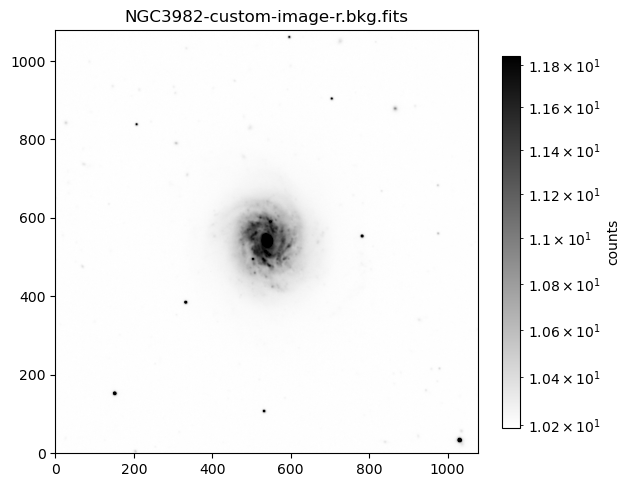

In [5]:
imname = 'NGC3982-custom-image-r.bkg.fits'
#fig,ax = plt.subplots(figsize=(6,6))
data,header = fits.getdata(imname, header=True)
fig,ax = imdisplay(data,v1perc=1,v2perc=99.9,logscale=True)

plt.title(imname)

This is a code that will take in an image name and data, as well as corners of background boxes, and will measure the background in two different ways.

In [6]:
def background_meas(imname,data,header,fig,ax,corners,bkg_size=5):
    #need to find ways to select regions of pixels in image
    fig,ax = imdisplay(data,v1perc=1,v2perc=99,logscale=True)

    plt.title(imname)

    #print out the x and y-dimension of the image using the header keywords
    print('image xdim = ', header['NAXIS1'], '; image ydim = ',header['NAXIS2'])
    #the length of each background box size
    #bkg_size = 200

    #make an array whose elements are the different data sections.
    reg = np.array([])


    #specify the different regions.  Each will be appended to the reg array.  the reg array is therefore 3 dimensional.  
    #the first dimension is for each region.  Each of those dimensions contains a 2D array that holds the image section.
    reg = np.append(reg, data[corners[0][0]:bkg_size-1, corners[0][1]:bkg_size-1])    #lower left corner
    reg = np.append(reg, data[corners[1][0]:bkg_size-1, corners[1][1]:])    #upper left corner
    reg = np.append(reg, data[corners[2][0]:, corners[2][1]:])    #upper right corner
    reg = np.append(reg, data[corners[3][0]:, corners[3][1]:bkg_size-1])   #lower right corner

    #print the median and mode of all the pixels. 
    bkgmode =stats.mode(reg,keepdims=False)[0]
    bkgmed = np.median(reg)
    print('mode = ',bkgmode)
    print('median = ',bkgmed)

    #Overlay rectangles with the background region indicated
    rectlist = []
    #loop through all images 
    for corn in corners:
        rect = plt.Rectangle((corn),bkg_size, bkg_size,linewidth=2,angle=0.0)
        rectlist.append(rect)
        pc = PatchCollection(rectlist,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_collection(pc)
        
    return bkgmode,bkgmed


Open the image in ds9 and use the log stretch to see if you can define corners of the image that are relatively free of galaxy light at a hard stretch.  You will compute the average pixel value in each of these regions and take the average.  It is ok if there are stars in these regions.  You should have 4 regions for the image.  An example that works for this image is shown below.  

**Note**
* to make it simpler, the boxes should be equal in size.  You will need to specify the lower left corner of each box.
* The images I am providing here have been selected from much larger images from the DESI Legacy Survey https://www.legacysurvey.org/viewer .  Therefore they do not have strange behavior around the edges and you can use the edges of the image as the edges of your sky region without any buffer region.

To make your coding easier, I'm going to make a bunch of dictionaries such that the main variable name is the same and you only have to change the galaxy name with the galname variable.

In [7]:
#initialize dictionaries that contains names of images and headers
imname = {}
data = {}
header = {}
corners = {}
bkgdim = {}

#statistics of background
bkgmode = {}
bkgmed = {}

In [8]:
#a routine to plot the images with the background measurement corners shown in red
def bkgregplot(data,header,imname, bkgdim, fig, ax):
    #define lower-left corners of each region
    corners = []
    corners.append([0,0])
    corners.append([0,header['NAXIS2']-bkgdim])
    corners.append([header['NAXIS1']-bkgdim, header['NAXIS2']-bkgdim])
    corners.append([header['NAXIS1']-bkgdim,0])

    #run the background_meas code to measure the background and plot the background regions
    bkgmode,bkgmed = background_meas(imname, data, header, fig, ax, 
                                                       corners,bkg_size=bkgdim)
    return bkgmode, bkgmed

### NGC3982

10.19071102142334 10.892627716064453
image xdim =  1079 ; image ydim =  1079
mode =  10.198768615722656
median =  10.20020866394043


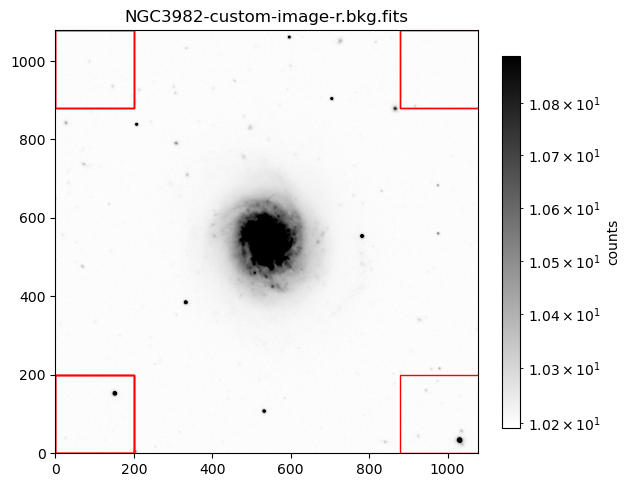

In [9]:
galname = 'NGC3982'
imname[galname] = 'NGC3982-custom-image-r.bkg.fits'

# reads in the data and header from fits
data[galname],header[galname] = fits.getdata(imname[galname], header=True)

# size of squares
bkgdim[galname]= 200

# plots image squares
bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)


### NGC5198

5.3430326461792 5.763217258453368
image xdim =  1131 ; image ydim =  1131
mode =  5.3495049476623535
median =  5.349852085113525


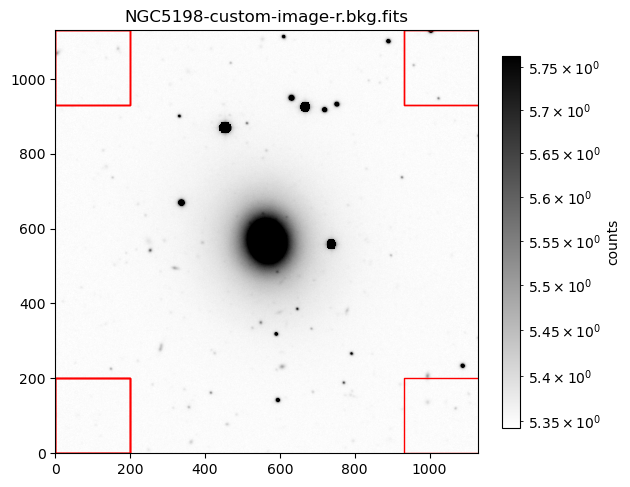

In [10]:
#*******************
#write your code here

galname = 'NGC5198'
imname[galname] = 'NGC5198-custom-image-r.bkg.fits'

# reads in the data and header from fits
data[galname],header[galname] = fits.getdata(imname[galname], header=True)

# size of squares
bkgdim[galname]= 200

# plots image squares
bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)


### NGC5985

22.116252899169922 22.362007522583006
image xdim =  2291 ; image ydim =  2291
mode =  22.122928619384766
median =  22.123065948486328


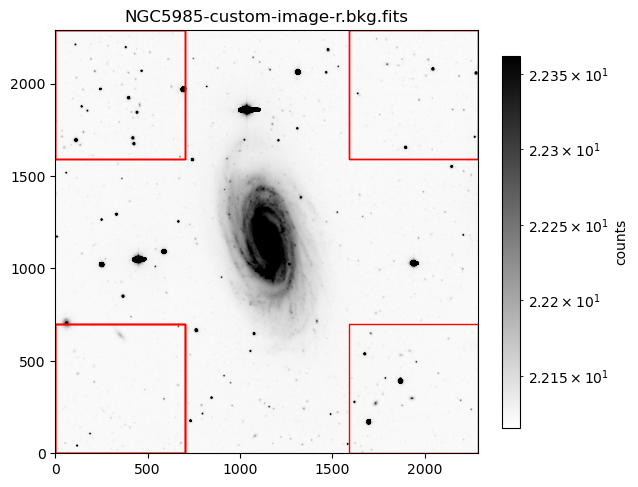

In [11]:
#*******************
#write your code here

galname = 'NGC5985'
imname[galname] = 'NGC5985-custom-image-r.bkg.fits'

# reads in the data and header from fits
data[galname],header[galname] = fits.getdata(imname[galname], header=True)

# size of squares
bkgdim[galname]= 700

# plots image squares
bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)


### PGC0997820

5.341621627807617 5.481662235260011
image xdim =  403 ; image ydim =  403
mode =  5.348475933074951
median =  5.350183010101318


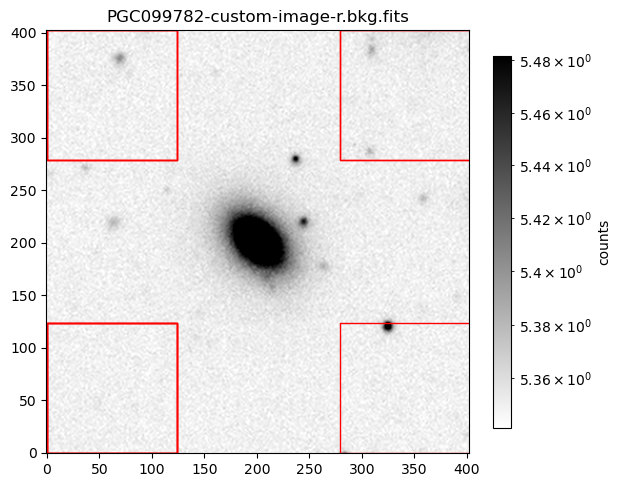

In [12]:
#*******************
#write your code here

galname = 'PGC0997820'
imname[galname] = 'PGC099782-custom-image-r.bkg.fits'

# reads in the data and header from fits
data[galname],header[galname] = fits.getdata(imname[galname], header=True)

# size of squares
bkgdim[galname]= 124

# plots image squares
bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)


#### 2. subtract background and display subtracted image

In this component you will need to:
* subtract your background from the previously read in image
* display that image
* write out your image

I provide one example below and you will need to do the other 3.  Note that since counts can be negative, you will need to choose v1perc to make sure that the lowest counts are positive.  The limits of the colorbar scale are printed after the imdisplay() command so you will see how far you are away.

In [13]:
#initializse dictionary that will hold background subtracted images
data_bsub = {}
imname_bsub = {}

### NGC 3982

8.296966552734375e-05 1.6422252273559677


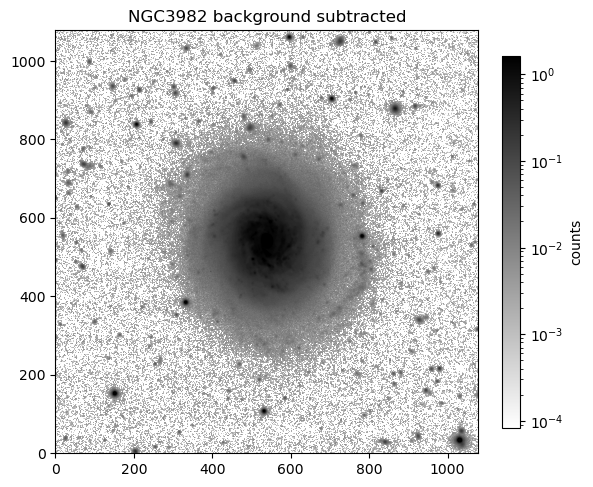

In [14]:
galname = 'NGC3982'

# subtracts the background from the data
data_bsub[galname] = data[galname] - bkgmed[galname]

# displays figure, background subtracted
fig,ax =imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)

# title
plt.title(galname + ' background subtracted')

# creates new file name, replaces bkg with bsub
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")

# saves background subtracted image as a fits file
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

### NGC 5198

0.0010209083557128906 10.000118255615234


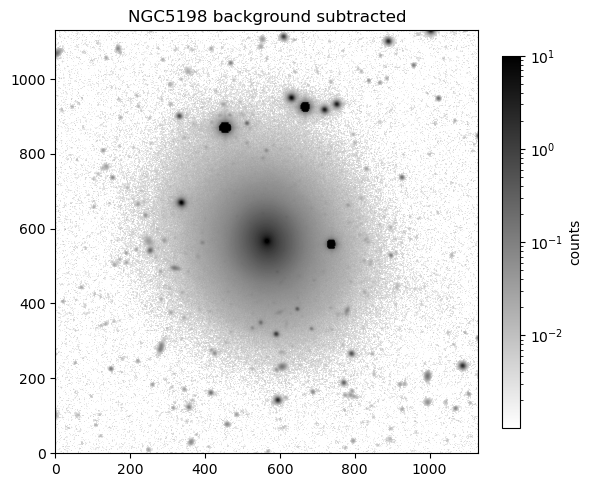

In [15]:
#***************
#your code goes here

galname = 'NGC5198'
# subtracts the background from the data
data_bsub[galname] = data[galname] - bkgmed[galname]

# displays figure, background subtracted
fig,ax =imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)

# title
plt.title(galname + ' background subtracted')

# creates new file name, replaces bkg with bsub
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")

# saves background subtracted image as a fits file
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])


### NGC 5985

0.0001163482666015625 9.999916076660156


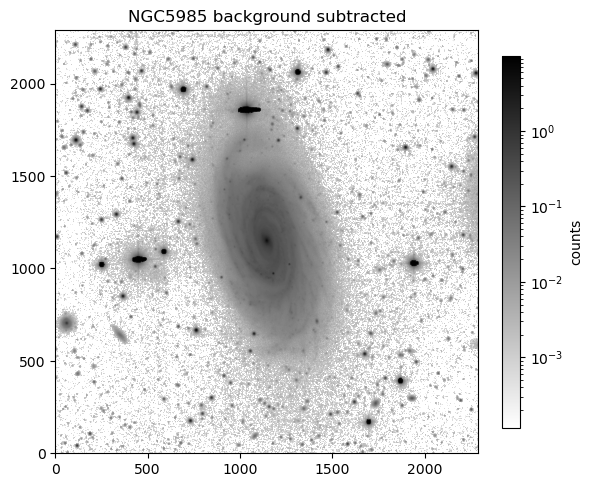

In [16]:
#***************
#your code goes here

galname = 'NGC5985'
# subtracts the background from the data
data_bsub[galname] = data[galname] - bkgmed[galname]

# displays figure, background subtracted
fig,ax =imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)

# title
plt.title(galname + ' background subtracted')

# creates new file name, replaces bkg with bsub
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")

# saves background subtracted image as a fits file
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])


### PGC 0997820

0.0013451576232910156 0.6761682891845744


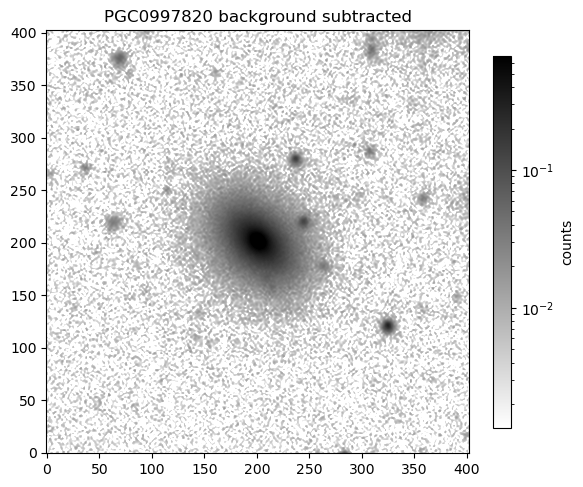

In [17]:
#***************
#your code goes here
galname = 'PGC0997820'

# subtracts the background from the data
# mode was used instead of median for this galaxy
data_bsub[galname] = data[galname] - bkgmode[galname]

# displays figure, background subtracted
fig,ax =imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)

# title
plt.title(galname + ' background subtracted')

# creates new file name, replaces bkg with bsub
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")

# saves background subtracted image as a fits file
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

**Question**: comment on the differences between the images with background and those with background subtracted.  Please describe why you think this is.

**put answer here.**
1. The bsub images appear to have a more "static" like background, this is because of the poisson noise. Poisson noise is existant in both of the images.
2. The details of the galaxy itself are more defined

Both of these are for the same reason, the removal of the background "amplifies" smaller variations.


## Problem 2 - estimate initial guesses for ellipse parameters (15 Points)
The `photutils` package that we will be using for doing our photometry requires initial guesses for the center, semi-major axis, ellipticity, and position angle.  We will measure these using DS9 on the background subtracted images.
* xcen, ycen: What you think the center is by using the cursor on ds9

* semi-major axis, ellipticity, PA: For the other items you will need to make an elliptical region in ds9 that matches where the brighter part of the galaxy is.  If you double click on the region it will bring up a dialog box that lets you adjust the PA and also will output the semi-major and semi-minor axes, which you will need for the ellipticity measurement.  You should display the information in pixels using the dropdown to the right of the `radius` field in the "Ellipse" window.  Choose `Image`

**Note**: In ds9, when the first radius in the `Ellipse` window is the semi-major axis, the PA is measured South of East.  This is the same sense as the Elliptical Isophote package in the following problem uses.

For each galaxy, provide these intial guesses.  I will be storing these as a python dictionary for each galaxy.

These guesses do not need to be super precise but they need to be in the right ballpark.

In [18]:
#initialize the dictionary containing the intial parameters for the ellipse fitting
initparams = {}

#### NGC 3982

In [19]:
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
'''
for all of the initparams, the values were 
derived from creating shapes in ds9,
as well as adjusting them in order to
get a reasonable fit to the data,
for later on in the notebook
'''

galname = 'NGC3982'
initparams[galname] = {}
#centroids [pixels]
initparams[galname]['xcen'] = 541
initparams[galname]['ycen'] = 541
#semi-major axis [pixels]
initparams[galname]['sma'] = 116
#semin-minor axis [pixels]
initparams[galname]['smina'] = 96
#ellipticity = 1-b/a
initparams[galname]['ellip'] = 1. - initparams[galname]['smina'] / initparams[galname]['sma'] 
#position angle, counterclockwise from the positive x-direction (right) [degrees]
initparams[galname]['PA'] = 90.0

#### NGC 5198

In [20]:
#*******************
#Your estimates go here.
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'NGC5198'
initparams[galname] = {}
#centroids [pixels]
initparams[galname]['xcen'] = 566
initparams[galname]['ycen'] = 566
#semi-major axis [pixels]
initparams[galname]['sma'] = 100
#semin-minor axis [pixels]
initparams[galname]['smina'] = 80
#ellipticity = 1-b/a
initparams[galname]['ellip'] = 1. - initparams[galname]['smina'] / initparams[galname]['sma'] 
#position angle, counterclockwise from the positive x-direction (right) [degrees]
initparams[galname]['PA'] = 130

#### NGC 5985

In [21]:
#*******************
#Your estimates go here.
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'NGC5985'
initparams[galname] = {}
#centroids [pixels]
initparams[galname]['xcen'] = 1155
initparams[galname]['ycen'] = 1145
#semi-major axis [pixels]
'''
sma and smina were made to be smaller
than the galaxy appears, this allows
for the fitting to work better, 
when using larger axis, the fitting
creates large annulus' that end up 
being filled with no signal.
'''
initparams[galname]['sma'] = 200
#semin-minor axis [pixels]
initparams[galname]['smina'] = 100
#ellipticity = 1-b/a
initparams[galname]['ellip'] = 1. - initparams[galname]['smina'] / initparams[galname]['sma'] 
#position angle, counterclockwise from the positive x-direction (right) [degrees]
initparams[galname]['PA'] = 100

PGC 0997820

In [22]:
#*******************
#Your estimates go here.
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'PGC0997820'
initparams[galname] = {}
#centroids [pixels]
initparams[galname]['xcen'] = 201
initparams[galname]['ycen'] = 201
#semi-major axis [pixels]
initparams[galname]['sma'] = 80
#semin-minor axis [pixels]
initparams[galname]['smina'] = 50
#ellipticity = 1-b/a
initparams[galname]['ellip'] = 1. - initparams[galname]['smina'] / initparams[galname]['sma'] 
#position angle, counterclockwise from the positive x-direction (right) [degrees]
initparams[galname]['PA'] = 130

## Problem 3 - fit elliptical isophotes and measure the radial profiles for various ellipse paramters (15 Points)

We will now use the `photutils.isophot()` task to fit elliptical isophotes (https://photutils.readthedocs.io/en/stable/isophote.html).  An "isophote" is a line of constant surface brightness, akin to a countour on a topographical map.  To get a visual representation of an isophote do the following:
* open one of the background subtracted images in ds9 and dislay it in log scale
* in the analysis menu open "contour parameters" and set the number of countours to 10.  Then hit `Generate` and then `Apply`

The green lines on your image connect pixels of identical flux.  Since the pixels have the same area within a given image, these lines therefore connect points of constant surface brightness.

The `photutils.isophote()` code that we will be using fits ellipses to the isophotes.

In [23]:
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture

#define an empty dictionary that will contain the EllipseGeometry instance
geometry = {}

 We must provide the elliptical isophote fitter with an initial ellipse to be fitted. This ellipse geometry is defined with the **EllipseGeometry** class. Here we’ll define an initial ellipse from our answer to problem 2.

### NGC 3982

116 0.1724137931034483
8.296966552734375e-05 6.612554946894021


Text(0.5, 1.0, 'NGC3982')

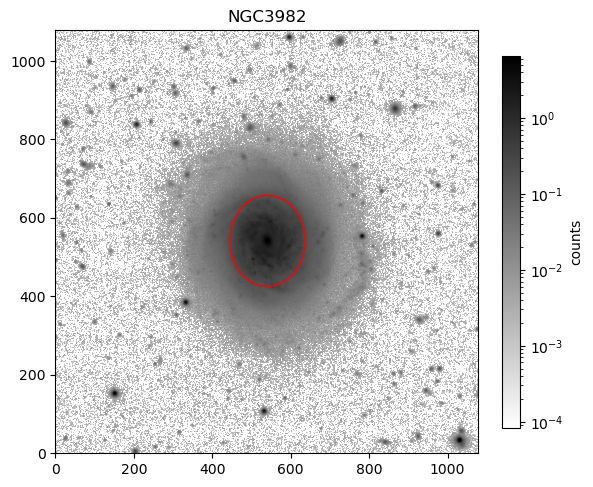

In [24]:
#set up the EllipseGeometry instance with the right initial guess parameters
'''
There are not really novel comments to be made on the plotting section. 
I personally would have done this w/ astropy regions, and I would have
included it in the initparams stage in order to circumvent using ds9.
'''
galname = 'NGC3982'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

print(geometry[galname].sma,geometry[galname].eps )
#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (1.-geometry[galname].eps), geometry[galname].pa)

#plot our image
#fig,ax = plt.subplots(figsize=(6,6))
fig,ax = imdisplay(data_bsub[galname],v1perc=40,v2perc=99.99,logscale=True)
aper.plot(color='red')
plt.title(galname)

### NGC 5198

100 0.19999999999999996
0.0010209083557128906 10.000194549560547


Text(0.5, 1.0, 'NGC5198')

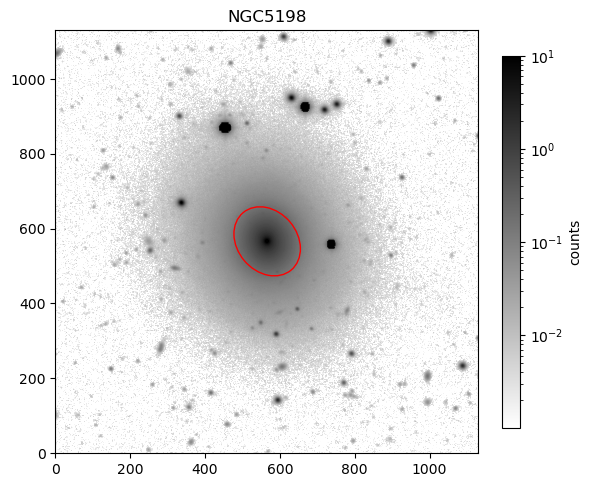

In [25]:
#***************************
#Your code here
#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'NGC5198'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

print(geometry[galname].sma,geometry[galname].eps )

aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (1.-geometry[galname].eps), geometry[galname].pa)

#plot our image
#fig,ax = plt.subplots(figsize=(6,6))
fig,ax = imdisplay(data_bsub[galname],v1perc=40,v2perc=99.99,logscale=True)
aper.plot(color='red')
plt.title(galname)

### NGC 5985

200 0.5
0.0001163482666015625 9.999977111816406


Text(0.5, 1.0, 'NGC5985')

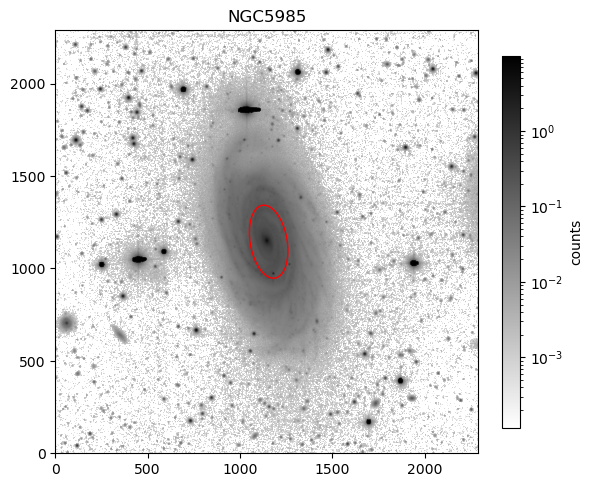

In [26]:
#***************************
#Your code here
#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'NGC5985'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

print(geometry[galname].sma,geometry[galname].eps )

aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (1.-geometry[galname].eps), geometry[galname].pa)

#plot our image
#fig,ax = plt.subplots(figsize=(6,6))
fig,ax = imdisplay(data_bsub[galname],v1perc=40,v2perc=99.99,logscale=True)
aper.plot(color='red')
plt.title(galname)

### PGC 0997820

80 0.375
0.0013451576232910156 1.2207054759978018


Text(0.5, 1.0, 'PGC0997820')

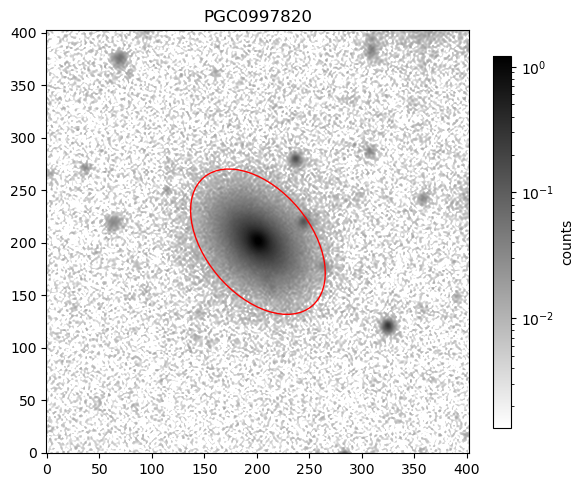

In [27]:
#***************************
#Your code here
#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'PGC0997820'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

print(geometry[galname].sma,geometry[galname].eps )

aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (1.-geometry[galname].eps), geometry[galname].pa)

#plot our image
#fig,ax = plt.subplots(figsize=(6,6))
fig,ax = imdisplay(data_bsub[galname],v1perc=40,v2perc=99.99,logscale=True)
aper.plot(color='red')
plt.title(galname)

**Question** For some of these galaxies, the PA is very important to get the apertures right.  Please tell me for which galaxies it is not very important, and why.


**put answer in this cell**

It is less important to get the correct PA on the less elliptical galaxies, because they are more circular. On a circle, PA is irrelevant, since a circle has complete rotational symmetry. The less circular the ellipse is, the more of the galaxy is excluded by an ellipse with a mismatched PA.

#### Some routines I wrote for you for the next parts
This is a subroutine I have written to plot our outputs of ellipse fitting

In [28]:
def plotellipse(isolist):
    plt.figure(figsize=(8, 8))
    plt.subplots_adjust(hspace=0.35, wspace=0.35)

    #plot the semi-major axis vs. the ellipticity
    plt.subplot(2, 2, 1)
    plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err,
                 fmt='o', markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('Ellipticity')

    #plot the semi-major axis vs. the PA
    plt.subplot(2, 2, 2)
    plt.errorbar(isolist.sma, isolist.pa / np.pi * 180.0,
                 yerr=isolist.pa_err / np.pi * 80.0, fmt='o', markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('PA (deg)')

    #plot the semi-major axis vs. the x center of that ellipse
    plt.subplot(2, 2, 3)
    plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o',
                 markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('x0')

    #plot the semi-major axis vs. the y center of that ellipse
    plt.subplot(2, 2, 4)
    plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o',
                 markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('y0')

This is a subroutine to plot all of the ellipses.  It plots one version where the ellipse has a free geometry at every isophote and one where I set the ellipses to have the same geometry at every semi-major axis.

In [29]:
#this subroutine will plot every other isophote on top of the galaxy image
def plotaper(galname, image, isophote_list,vminperc=40,vmaxperc=99.99):

    #plot image
    #plt.subplots(figsize=(6,6))
    fig,ax = imdisplay2(image,v1perc=vminperc,v2perc=vmaxperc,logscale=True)

    #Loop through all apertures starting at the first (not zero) and going to every other aperture
    for i in range(1, len(isophote_list.sma),2):
        #create an elliptical aperture with the the correct geometry.  
        #Task is described here https://photutils.readthedocs.io/en/stable/api/photutils.aperture.EllipticalAperture.html#photutils.aperture.EllipticalAperture
        aperiter = EllipticalAperture((isophote_list.x0[i], isophote_list.y0[i]), isophote_list.sma[i], 
                                      isophote_list.sma[i] * (1-isophote_list.eps[i]), isophote_list.pa[i])
    
        #overplot apertures
        aperiter.plot(ax=ax[0],color='red')

    #plot the isophotes that have parameters fixed to the median parameters of all but the "apmin" inner isphotes
    #compute median isophote parameters ignoring inner isophotes.  This is because the inner isophotes all tend to be rather circular
    apmin = 20   #the minimum inner isophote in terms of isophote number.
    xcenav = np.median(isophote_list.x0[apmin:])
    ycenav = np.median(isophote_list.y0[apmin:])
    epsav = np.median(isophote_list.eps[apmin:])
    paav = np.median(isophote_list.pa[apmin:])
    
    #fig,ax = imdisplay(image,v1perc=vminperc,v2perc=vmaxperc,logscale=True)
    for i in range(1, len(isophote_list.sma),2):
        #create an elliptical aperture with the the correct geometry.  
        #Task is described here https://photutils.readthedocs.io/en/stable/api/photutils.aperture.EllipticalAperture.html#photutils.aperture.EllipticalAperture
        aperiter = EllipticalAperture((xcenav, ycenav), isophote_list.sma[i], 
                                      isophote_list.sma[i] * (1-epsav), paav)
    
        #overplot apertures
        aperiter.plot(ax=ax[1],color='blue')

    ax[0].set_title(galname + ' free ellipse parameters')
    ax[1].set_title(galname + ' fixed ellipse parameters')

    return xcenav, ycenav, epsav, paav

Next, we create an instance of the Ellipse class, inputting the data to be fitted and the initial ellipse geometry object:

In [30]:
from photutils.isophote import Ellipse

#initialize dictionary for ellipse fitting
ellipse = {}
isolist = {}

The values computed by the fitting process are the attributes at this table https://photutils.readthedocs.io/en/stable/api/photutils.isophote.Isophote.html#photutils.isophote.Isophote

I will do the first galaxy for you and you will need to do the other three

### NGC 3982

In [31]:
xcenav = {}
ycenav = {}
epsav = {}
paav = {}

In [32]:
#this will do the fitting of the isophotes by making an instance of the Ellipse class
#It then fits the data using the initial guesses we computed above
galname = 'NGC3982'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

v1 =  0.00, v2 =  6.61


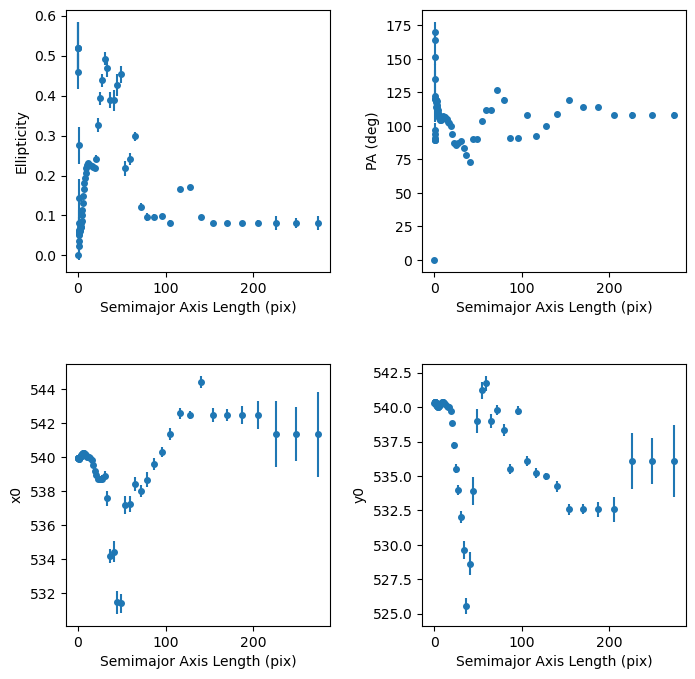

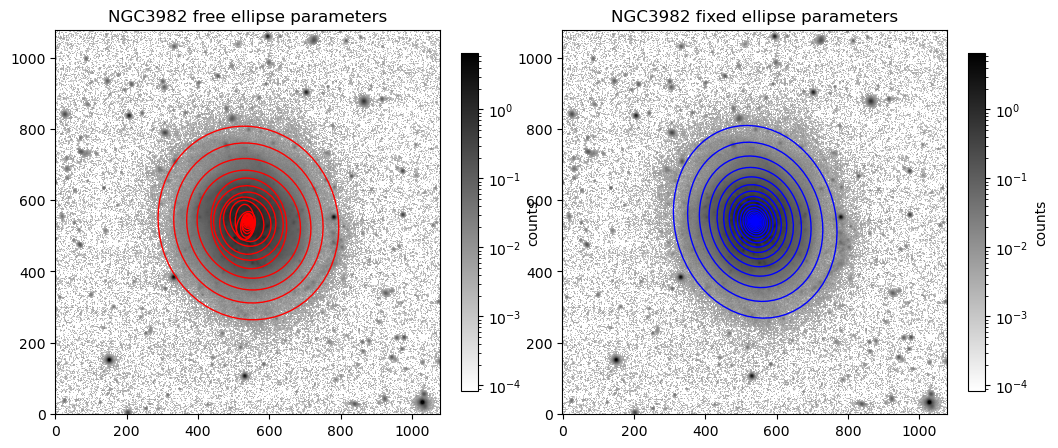

In [33]:
#this puts the output into a table containing every ellipse.   
#You can comment this first line out if you don't want it always to print out.
#print(isolist[galname].eps)

#make a set of plots that show some attributes of every ellipse.
plotellipse(isolist[galname])
#save the shape values of the average ellipse.  We will need this later for aperture photometry
xcenav[galname], ycenav[galname], epsav[galname], paav[galname] = plotaper(galname, data_bsub[galname],isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the images and the apertures, as viewed in the cells above or in ds9

**put answer in this cell**\
1. Ellipticity
- Starts circular, becomes somewhat elliptical, and then returns to being relatively circular again
2. PA
- shifts clockwise, counterclockwise, clockwise, counterclockwise, clockwise and then levels out at 100 degs
3. x0
- decrease, increase, level out
4. y0
- relatively unstable, theres probably a better fit to the image. 
5. free ellipse
- the changing in PA indicates, to me that this galaxy is a spiral galaxy.


### NGC 5198

In [34]:
galname = 'NGC5198'
'''
creates ellipse object using bsub data and the geometry and
our initial ellipse (geometry[galname]). Then, the data is
fit using our ellipse object. This creates a list of isophotes,
contours, in which the light is ~ constant value, this is done
for the extent of the galaxy. This comment will not be repeated
because it should be the exact same for the other galaxies.
'''
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

v1 =  0.00, v2 = 10.00


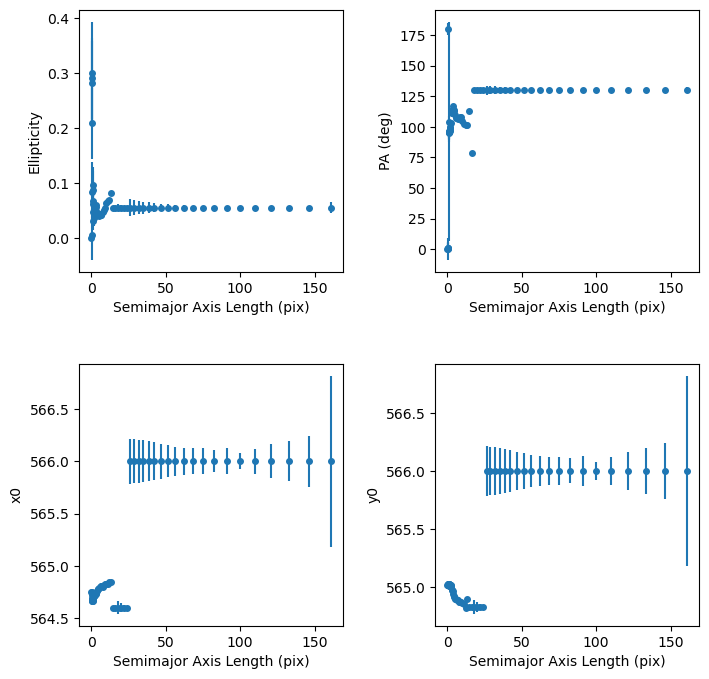

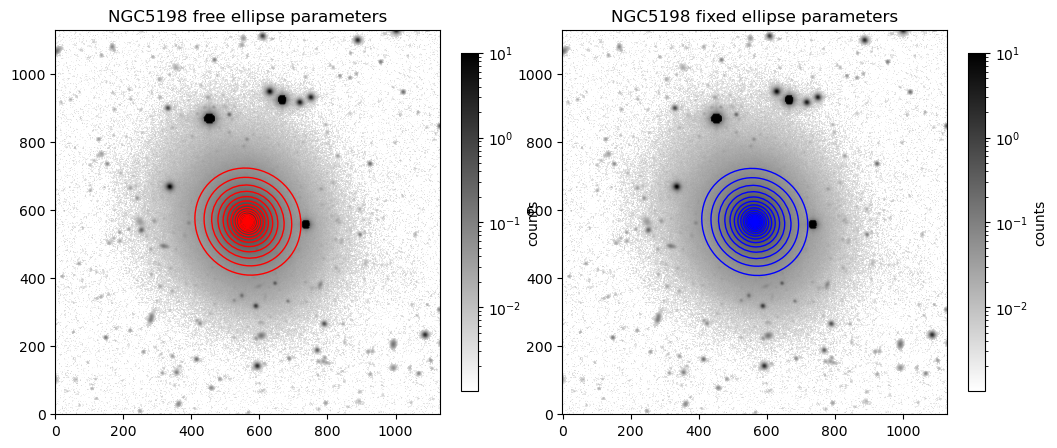

In [35]:
'''
plots:
ellipticity vs sma length
PA vs sma length,
x0 vs sma length,
and
y0 vs sma length using  the
plot ellipse function.
'''

plotellipse(isolist[galname])

# plots the apetures and saves relevant quantites on each ellipse
xcenav[galname], ycenav[galname], epsav[galname], paav[galname] = plotaper(galname, data_bsub[galname],isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the images and the apertures, as viewed in the cells above or in ds9

**put answer in this cell**
1. Ellipticity
- we see that the ellipticity is relatively constant and low
2. PA
- more or less constant
3. x0
- more or less constant
4. y0
- more or less constant
5. free ellipse
- reflects upper plots, shows concentric ellipses
6. fixed ellipse
- agrees with free ellipse well.

This galaxy does not have any variation in its ellipse parameters as its sma changes, this, too me looks like an elliptical galaxy and I would guess that is why it has these properties

### NGC 5985

In [36]:
galname = 'NGC5985'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
# init params had to be modified in order to get a fitting without noise-dominated
# annulus'
isolist[galname] = ellipse[galname].fit_image()

v1 =  0.00, v2 = 10.00


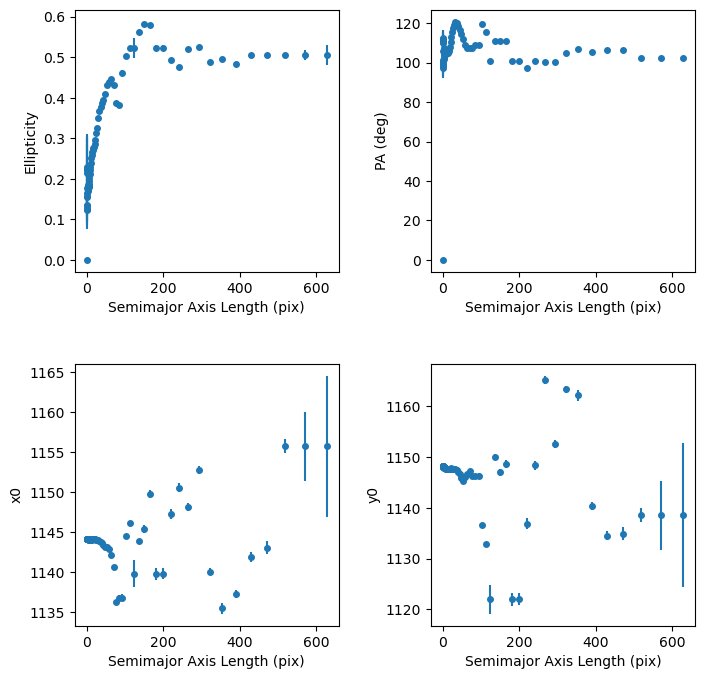

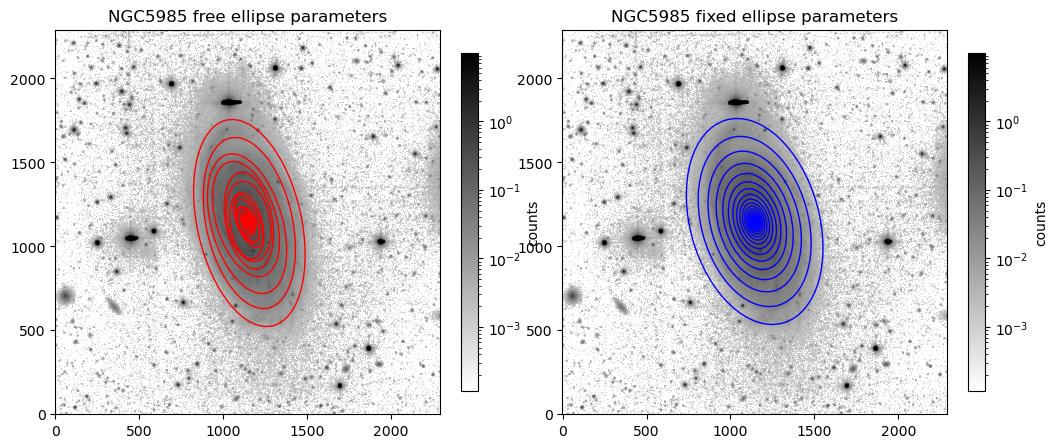

In [37]:
plotellipse(isolist[galname])
xcenav[galname], ycenav[galname], epsav[galname], paav[galname] = plotaper(galname, data_bsub[galname],isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the images and the apertures, as viewed in the cells above or in ds9

**put answer in this cell**
1. Ellipticity
- the contours get more and more eliptical
2. PA
- shifts counterclockwise, clockwise and then levels off ~ 100 deg
3. x0 & y0
- truthfully, I can not make a whole lot of commentary on these plots
4. free ellipse
- this however, I can make comment on. This is more clearly a spiral galaxy (seen from the changing PA). The shifting x0 and y0 along with the differeent PA actually help to produce spiral arms from the contours. It also appears that this galaxy is inclined and that leads to some of the effects of the fitting.


### PGC 0997820

In [38]:
#this will do the fitting of the isophotes by making an instance of the Ellipse class
#It then fits the data using the initial guesses we computed above
galname = 'PGC0997820'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

v1 =  0.00, v2 =  1.22


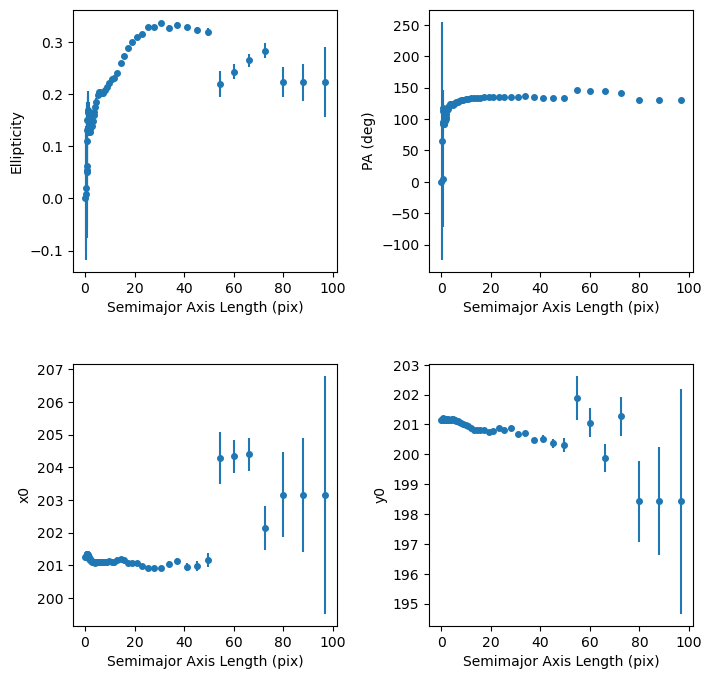

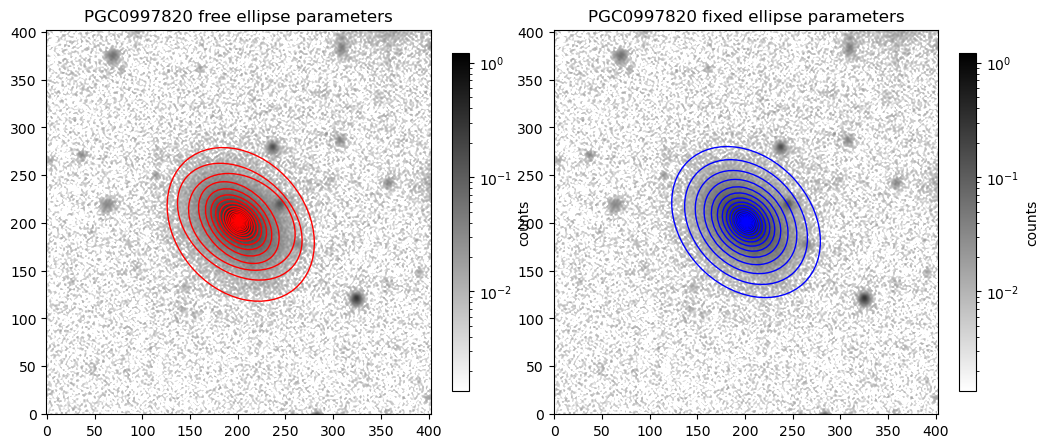

In [39]:
#this puts the output into a table containing every ellipse.   
#You can comment this first line out if you don't want it always to print out.
#print(isolist[galname].eps)

#make a set of plots that show some attributes of every ellipse.
plotellipse(isolist[galname])
#save the shape values of the average ellipse.  We will need this later for aperture photometry
xcenav[galname], ycenav[galname], epsav[galname], paav[galname] = plotaper(galname, data_bsub[galname],isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the images and the apertures, as viewed in the cells above or in ds9

**put answer in this cell**
1. Ellipticity
- Grows in ellipticity, starting out relatively circular
2. PA
- remains more or less constant
3. x0
- more or less constant, with a shift at the end
4. y0
- more or less constant, with a shift at the end
5. free ellipse
- This appears to me to be a galaxy with an elliptical shape (I can't say its specific morphological class), and a spherical nucleus.


**Question** In light of the differences between the free ellipse geometry and the constrained ellipse geometry, discuss the advantages and disadvantages are of the two in regards to measuring the shape of the isophotes and in measuring the flux profiles.

**put answer in this cell**

The free ellipse seems to be better at displaying the morphology of the galaxy, but this seems to be a bit shaky and it will create differently shaped annuli. The fixed annuli will be better for photometry in the way that it is more consistent with regards to shape. A fixed ellipse works best for a face on galaxy, so inclination is something to keep in mind.

## Problem 4 - construct curves of growth, radial surface brightness profiles, and measure half-light radii (10 Points)

In this problem we will measure the half-light (or effective) radius of every galaxy.  To do this we will first create something called a "curve of growth", which shows how much light you get within each aperture.  As you increase in radius this cumulative flux grows.  We will also plot a surface brightness profile, which is the average surface brightness in each annulus.  We will use the annuli that have fixed ellipse geometries from above.

For the purpose of these plots, we will use the ellipse centers, ellipticity, and position angle that we determined as the median of all the ellipses in the previous exercise.

First you will need to complete the code for each galaxy to measure the curve of growth, half-light radius, and surface brightness profile.

In each code block you will need to:
* measure the total flux in each elliptical aperture
* calculate its uncertainty
* Use this to determine the radius within which 50% of the light is contained
* measure mean surface brightness in mag/asec^2 in each annulus
* calculate its uncertainty
* plot the surface brightness profile
* determine the surface brightness at the center and at the half-light radius and compare them.

**Notes** There will also be questions at the end that you will need to answer.

In [40]:
from photutils.aperture import ApertureStats
from photutils.aperture import EllipticalAnnulus, EllipticalAperture

In [41]:
#initialize dictionary for half-light radii
rhalfasec = {}

### NGC 3982

the half-light radius = 18.300 [asec]
surface brightness at center: 4.636 mag
surface brightness at r half: 0.147 mag
flux_SB(rhalf) / flux_SB(rcent) = 62.473


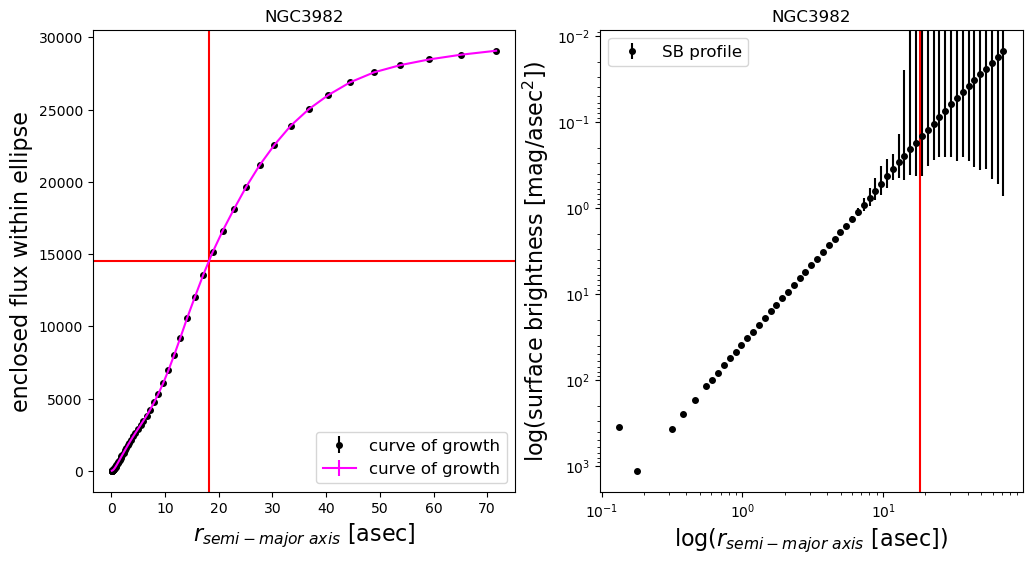

In [84]:
galname = 'NGC3982'  # galay name
mag_zeropoint = header[galname]['MAGZERO']  # magnitude zeropoint
pixel_scale = header[galname]['CD2_2'] * 3600    # in asec/pix
central_radius = np.array([])  # central radius array
surface_brightness = np.array([])  # array of surface brightnesses for each annulus, magnitudes
surface_brightness_error = np.array([])  # array of error on surface brightnesses, magnitudes
total_flux = np.array([])  # flux enclosed within entire ellipse
total_flux_error = np.array([])  # error on total flux

inner_sma = 0.01   # assigns initial inner radius of annulus
# iterates through each ellipse's semi-major axis (sma) starting at the second element
for outer_sma in isolist[galname].sma[1:]:
    # calculates semi-minor axis (smina) given sma and ellipticity
    outer_smina = outer_sma * (1.-epsav[galname])
    inner_smina = inner_sma * (1.-epsav[galname])

    # set up elliptical annulus between each ellipse and its predecessor
    annulus_aperture = EllipticalAnnulus((xcenav[galname],ycenav[galname]), 
                                         inner_sma, outer_sma, outer_smina, b_in = inner_smina,
                                         theta = paav[galname])
    # set up elliptical aperture for each ellipse
    total_aperture = EllipticalAperture((xcenav[galname],ycenav[galname]), 
                                         outer_sma, outer_smina, theta = paav[galname])
    # calculates stats on annulus
    annulus_stats = ApertureStats(data_bsub[galname],annulus_aperture)
    # calculates stats on total aperture
    total_stats = ApertureStats(data_bsub[galname],total_aperture)
    # sets inner_sma equal to current outer_sma for the next iteration
    inner_sma = outer_sma
    
    # the central radius of each annulus in asec. 
    central_radius = np.append(central_radius, ((inner_sma+outer_sma)/2.)*pixel_scale)
    # the average pixel flux within each annulus
    annulus_mean_flux = annulus_stats.mean
    # the standard deviation of the pixel values within each annulus
    annulus_std_flux = annulus_stats.std
    # the number of pixels in each annulus
    annulus_num_pixels = annulus_stats.sum_aper_area

    # total flux for the aperture
    total_flux = np.append(total_flux, total_stats.sum)
    # error on total flux for the aperture
    total_flux_error = np.append(total_flux_error, total_stats.std)
    #****************************
    #your code here
    # asec2 per pixel, removes units 
    pixel_area = pixel_scale ** 2 * u.pix**-2
    # area of annulus in asec2
    annulus_area_asec2 = pixel_area * annulus_num_pixels
    # converts mean flux to instrumental magnitude and then adds zp to get calibrated magnitude
    annulus_mean_magnitude = -2.5 * np.log(annulus_mean_flux) + mag_zeropoint
    # average surface brightness of annulus, in magnitudes per asec2
    annulus_surface_brightness = annulus_mean_magnitude / annulus_area_asec2
    # appends our surface brightness array w/ surface brightness for this annulus
    surface_brightness = np.append(surface_brightness, annulus_surface_brightness)
    # calculates error on annulus magnitude
    annulus_mag_error = annulus_std_flux / (annulus_mean_flux * u.pix)
    # this gets rid of the units on the magnitude error so that the next part works
    annulus_mag_error = annulus_mag_error * u.pix
    surface_brightness_error = np.append(surface_brightness_error, annulus_mag_error)

# initializes figure
fig,ax = plt.subplots(1,2,figsize=(12, 6))
# plot the semi-major axis vs. magnitude
ax[1].errorbar(central_radius, surface_brightness, yerr=surface_brightness_error, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax[1].invert_yaxis()
ax[1].legend(fontsize=12)
ax[1].set_xlabel('log($r_{semi-major~axis}$ [asec])',fontsize=16)
ax[1].set_ylabel('log(surface brightness [mag/asec$^2$])',fontsize=16)
# I took the liberty of plotting SB as log to differentiate
# differences in the curves easeier to answer problem 5.
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_title(galname)

# plot the curve of growth
ax[0].errorbar(central_radius, total_flux, yerr=total_flux_error, 
             fmt='o', markersize=4, color='black', label='curve of growth')
ax[0].errorbar(central_radius, total_flux, yerr=total_flux_error, 
             fmt='-', markersize=4, color='magenta', label='curve of growth')
ax[0].legend(fontsize=12)
ax[0].set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax[0].set_ylabel('enclosed flux within ellipse',fontsize=16)
ax[0].set_title(galname)

#a horizontal line at half the total flux
ax[0].axhline(total_flux[-1]/2., color='red')
# by eye estimate of what radius on curve cooresponds to half flux
rhalfasec[galname] = 18.3  
# plots the vertical line
ax[0].axvline(rhalfasec[galname], color='red')
# prints estimate
print(f'the half-light radius = {rhalfasec[galname]:.3f} [asec]')

#plot the same line on the surface brightness plot
ax[1].axvline(rhalfasec[galname], color='red', label='$r_{half}$')

# finds radius closest to 3 asecs (estimate of center), finds
# surface brightness at that radius
inner_radius = 3  # asecs
# list of difference between each radius and 3 asecs
distance_to_inner = central_radius - inner_radius
# index of radius with smallest difference to 3 asecs
inner_index = np.argmin(abs(distance_to_inner))
# surface brightness at said radius
inner_surface_brightness = surface_brightness[inner_index]
print(f'surface brightness at center: {inner_surface_brightness:.3f} mag')

# finds the isophote that best corresponds to the half-light radius
# uses the same technique of finding the difference between desired radius
# and the list of central radii, finds the surface brightness at said radius
diff = central_radius - rhalfasec[galname]
rhalfasecind = np.argmin(abs(diff))
half_surface_brightness = surface_brightness[rhalfasecind]
print(f'surface brightness at r half: {half_surface_brightness:.3f} mag')

#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
half_surface_brightness_flux = 10**(-0.4*half_surface_brightness)  # magnitude to maggies
inner_surface_brightness_flux = 10**(-0.4*inner_surface_brightness)  # magnitude to maggies
flux_rat =  half_surface_brightness_flux / inner_surface_brightness_flux  # ratio of both fluxes
print(f'flux_SB(rhalf) / flux_SB(rcent) = {flux_rat:.3f}')

### NGC 5198

the half-light radius = 12.600 [asec]
surface brightness at center: 4.362 mag
surface brightness at r half: 0.307 mag
flux_SB(rhalf) / flux_SB(rcent) = 41.876


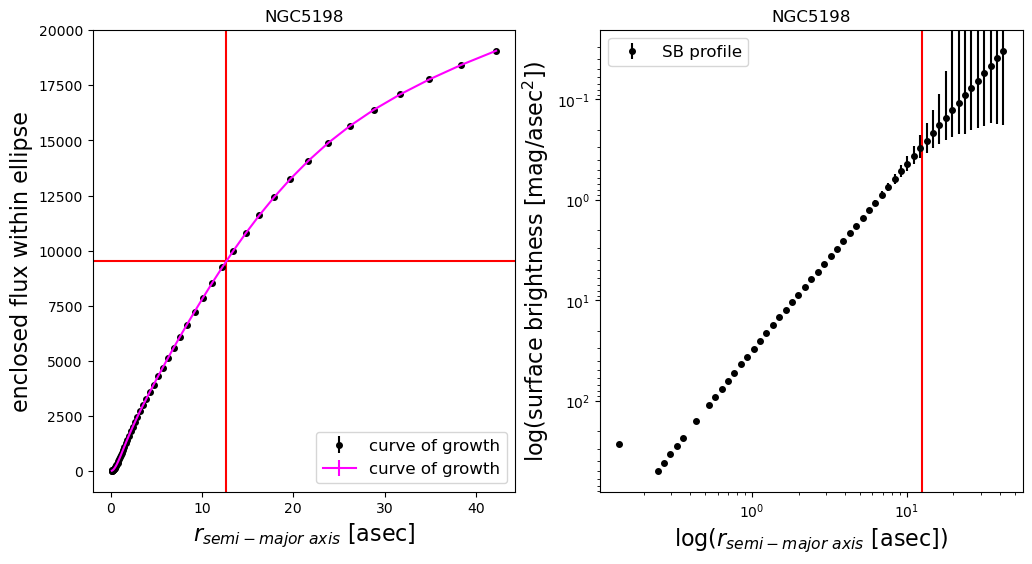

In [95]:
galname = 'NGC5198'
mag_zeropoint = header[galname]['MAGZERO']  # magnitude zeropoint
pixel_scale = header[galname]['CD2_2'] * 3600    # in asec/pix
central_radius = np.array([])  # central radius array
surface_brightness = np.array([])  # array of surface brightnesses for each annulus, magnitudes
surface_brightness_error = np.array([])  # array of error on surface brightnesses, magnitudes
total_flux = np.array([])  # flux enclosed within entire ellipse
total_flux_error = np.array([])  # error on total flux

inner_sma = 0.01   # assigns initial inner radius of annulus
# iterates through each ellipse's semi-major axis (sma) starting at the second element
for outer_sma in isolist[galname].sma[1:]:
    # calculates semi-minor axis (smina) given sma and ellipticity
    outer_smina = outer_sma * (1.-epsav[galname])
    inner_smina = inner_sma * (1.-epsav[galname])

    # set up elliptical annulus between each ellipse and its predecessor
    annulus_aperture = EllipticalAnnulus((xcenav[galname],ycenav[galname]), 
                                         inner_sma, outer_sma, outer_smina, b_in = inner_smina,
                                         theta = paav[galname])
    # set up elliptical aperture for each ellipse
    total_aperture = EllipticalAperture((xcenav[galname],ycenav[galname]), 
                                         outer_sma, outer_smina, theta = paav[galname])
    # calculates stats on annulus
    annulus_stats = ApertureStats(data_bsub[galname],annulus_aperture)
    # calculates stats on total aperture
    total_stats = ApertureStats(data_bsub[galname],total_aperture)
    # sets inner_sma equal to current outer_sma for the next iteration
    inner_sma = outer_sma
    
    # the central radius of each annulus in asec. 
    central_radius = np.append(central_radius, ((inner_sma+outer_sma)/2.)*pixel_scale)
    # the average pixel flux within each annulus
    annulus_mean_flux = annulus_stats.mean
    # the standard deviation of the pixel values within each annulus
    annulus_std_flux = annulus_stats.std
    # the number of pixels in each annulus
    annulus_num_pixels = annulus_stats.sum_aper_area

    # total flux for the aperture
    total_flux = np.append(total_flux, total_stats.sum)
    # error on total flux for the aperture
    total_flux_error = np.append(total_flux_error, total_stats.std)
    #****************************
    #your code here
    # asec2 per pixel, removes units 
    pixel_area = pixel_scale ** 2 * u.pix**-2
    # area of annulus in asec2
    annulus_area_asec2 = pixel_area * annulus_num_pixels
    # converts mean flux to instrumental magnitude and then adds zp to get calibrated magnitude
    annulus_mean_magnitude = -2.5 * np.log(annulus_mean_flux) + mag_zeropoint
    # average surface brightness of annulus, in magnitudes per asec2
    annulus_surface_brightness = annulus_mean_magnitude / annulus_area_asec2
    # appends our surface brightness array w/ surface brightness for this annulus
    surface_brightness = np.append(surface_brightness, annulus_surface_brightness)
    # calculates error on annulus magnitude
    annulus_mag_error = annulus_std_flux / (annulus_mean_flux * u.pix)
    # this gets rid of the units on the magnitude error so that the next part works
    annulus_mag_error = annulus_mag_error * u.pix
    surface_brightness_error = np.append(surface_brightness_error, annulus_mag_error)

# initializes figure
fig,ax = plt.subplots(1,2,figsize=(12, 6))
# plot the semi-major axis vs. magnitude
ax[1].errorbar(central_radius, surface_brightness, yerr=surface_brightness_error, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax[1].invert_yaxis()
ax[1].legend(fontsize=12)
ax[1].set_xlabel('log($r_{semi-major~axis}$ [asec])',fontsize=16)
ax[1].set_ylabel('log(surface brightness [mag/asec$^2$])',fontsize=16)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_title(galname)

# plot the curve of growth
ax[0].errorbar(central_radius, total_flux, yerr=total_flux_error, 
             fmt='o', markersize=4, color='black', label='curve of growth')
ax[0].errorbar(central_radius, total_flux, yerr=total_flux_error, 
             fmt='-', markersize=4, color='magenta', label='curve of growth')
ax[0].legend(fontsize=12)
ax[0].set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax[0].set_ylabel('enclosed flux within ellipse',fontsize=16)
ax[0].set_title(galname)

#a horizontal line at half the total flux
ax[0].axhline(total_flux[-1]/2., color='red')
# by eye estimate of what radius on curve cooresponds to half flux
rhalfasec[galname] = 12.6 
# plots the vertical line
ax[0].axvline(rhalfasec[galname], color='red')
# prints estimate
print(f'the half-light radius = {rhalfasec[galname]:.3f} [asec]')

#plot the same line on the surface brightness plot
ax[1].axvline(rhalfasec[galname], color='red', label='$r_{half}$')

# finds radius closest to 3 asecs (estimate of center), finds
# surface brightness at that radius
inner_radius = 3  # asecs
# list of difference between each radius and 3 asecs
distance_to_inner = central_radius - inner_radius
# index of radius with smallest difference to 3 asecs
inner_index = np.argmin(abs(distance_to_inner))
# surface brightness at said radius
inner_surface_brightness = surface_brightness[inner_index]
print(f'surface brightness at center: {inner_surface_brightness:.3f} mag')

# finds the isophote that best corresponds to the half-light radius
# uses the same technique of finding the difference between desired radius
# and the list of central radii, finds the surface brightness at said radius
diff = central_radius - rhalfasec[galname]
rhalfasecind = np.argmin(abs(diff))
half_surface_brightness = surface_brightness[rhalfasecind]
print(f'surface brightness at r half: {half_surface_brightness:.3f} mag')

#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
half_surface_brightness_flux = 10**(-0.4*half_surface_brightness)  # magnitude to maggies
inner_surface_brightness_flux = 10**(-0.4*inner_surface_brightness)  # magnitude to maggies
flux_rat =  half_surface_brightness_flux / inner_surface_brightness_flux  # ratio of both fluxes
print(f'flux_SB(rhalf) / flux_SB(rcent) = {flux_rat:.3f}')

### NGC 5985

the half-light radius = 56.000 [asec]
surface brightness at center: 6.732 mag
surface brightness at r half: 0.024 mag
flux_SB(rhalf) / flux_SB(rcent) = 482.270


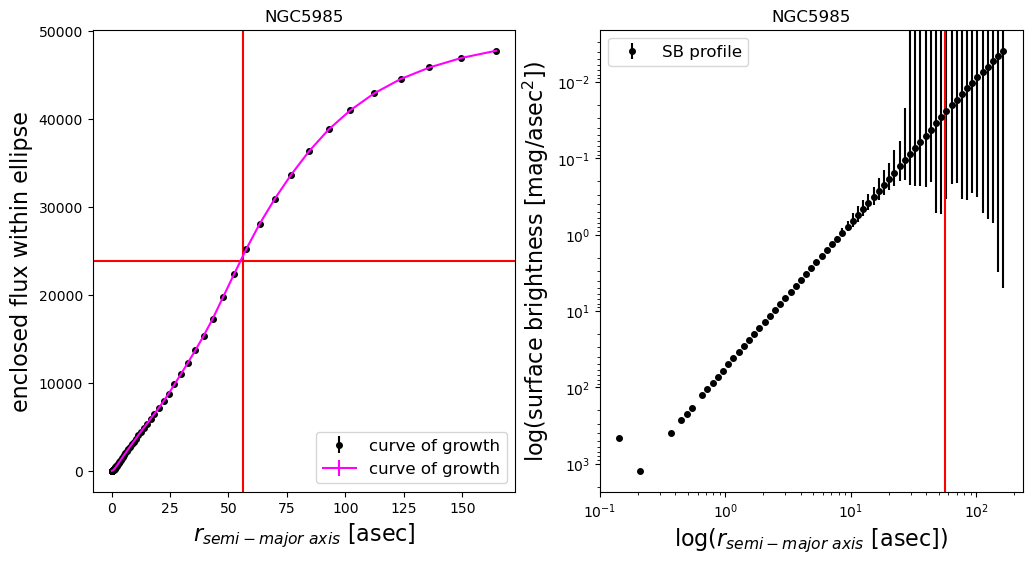

In [117]:
galname = 'NGC5985'

#***********************
#your code here

mag_zeropoint = header[galname]['MAGZERO']  # magnitude zeropoint
pixel_scale = header[galname]['CD2_2'] * 3600    # in asec/pix
central_radius = np.array([])  # central radius array
surface_brightness = np.array([])  # array of surface brightnesses for each annulus, magnitudes
surface_brightness_error = np.array([])  # array of error on surface brightnesses, magnitudes
total_flux = np.array([])  # flux enclosed within entire ellipse
total_flux_error = np.array([])  # error on total flux

inner_sma = 0.01   # assigns initial inner radius of annulus
# iterates through each ellipse's semi-major axis (sma) starting at the second element
for outer_sma in isolist[galname].sma[1:]:
    # calculates semi-minor axis (smina) given sma and ellipticity
    outer_smina = outer_sma * (1.-epsav[galname])
    inner_smina = inner_sma * (1.-epsav[galname])

    # set up elliptical annulus between each ellipse and its predecessor
    annulus_aperture = EllipticalAnnulus((xcenav[galname],ycenav[galname]), 
                                         inner_sma, outer_sma, outer_smina, b_in = inner_smina,
                                         theta = paav[galname])
    # set up elliptical aperture for each ellipse
    total_aperture = EllipticalAperture((xcenav[galname],ycenav[galname]), 
                                         outer_sma, outer_smina, theta = paav[galname])
    # calculates stats on annulus
    annulus_stats = ApertureStats(data_bsub[galname],annulus_aperture)
    # calculates stats on total aperture
    total_stats = ApertureStats(data_bsub[galname],total_aperture)
    # sets inner_sma equal to current outer_sma for the next iteration
    inner_sma = outer_sma
    
    # the central radius of each annulus in asec. 
    central_radius = np.append(central_radius, ((inner_sma+outer_sma)/2.)*pixel_scale)
    # the average pixel flux within each annulus
    annulus_mean_flux = annulus_stats.mean
    # the standard deviation of the pixel values within each annulus
    annulus_std_flux = annulus_stats.std
    # the number of pixels in each annulus
    annulus_num_pixels = annulus_stats.sum_aper_area

    # total flux for the aperture
    total_flux = np.append(total_flux, total_stats.sum)
    # error on total flux for the aperture
    total_flux_error = np.append(total_flux_error, total_stats.std)
    #****************************
    #your code here
    # asec2 per pixel, removes units 
    pixel_area = pixel_scale ** 2 * u.pix**-2
    # area of annulus in asec2
    annulus_area_asec2 = pixel_area * annulus_num_pixels
    # converts mean flux to instrumental magnitude and then adds zp to get calibrated magnitude
    annulus_mean_magnitude = -2.5 * np.log(annulus_mean_flux) + mag_zeropoint
    # average surface brightness of annulus, in magnitudes per asec2
    annulus_surface_brightness = annulus_mean_magnitude / annulus_area_asec2
    # appends our surface brightness array w/ surface brightness for this annulus
    surface_brightness = np.append(surface_brightness, annulus_surface_brightness)
    # calculates error on annulus magnitude
    annulus_mag_error = annulus_std_flux / (annulus_mean_flux * u.pix)
    # this gets rid of the units on the magnitude error so that the next part works
    annulus_mag_error = annulus_mag_error * u.pix
    surface_brightness_error = np.append(surface_brightness_error, annulus_mag_error)

# initializes figure
fig,ax = plt.subplots(1,2,figsize=(12, 6))
# plot the semi-major axis vs. magnitude
ax[1].errorbar(central_radius, surface_brightness, yerr=surface_brightness_error, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax[1].invert_yaxis()
ax[1].legend(fontsize=12)
ax[1].set_xlabel('log($r_{semi-major~axis}$ [asec])',fontsize=16)
ax[1].set_ylabel('log(surface brightness [mag/asec$^2$])',fontsize=16)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_title(galname)

# plot the curve of growth
ax[0].errorbar(central_radius, total_flux, yerr=total_flux_error, 
             fmt='o', markersize=4, color='black', label='curve of growth')
ax[0].errorbar(central_radius, total_flux, yerr=total_flux_error, 
             fmt='-', markersize=4, color='magenta', label='curve of growth')
ax[0].legend(fontsize=12)
ax[0].set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax[0].set_ylabel('enclosed flux within ellipse',fontsize=16)
ax[0].set_title(galname)

#a horizontal line at half the total flux
ax[0].axhline(total_flux[-1]/2., color='red')
# by eye estimate of what radius on curve cooresponds to half flux
rhalfasec[galname] = 56
# plots the vertical line
ax[0].axvline(rhalfasec[galname], color='red')
# prints estimate
print(f'the half-light radius = {rhalfasec[galname]:.3f} [asec]')

#plot the same line on the surface brightness plot
ax[1].axvline(rhalfasec[galname], color='red', label='$r_{half}$')

# finds radius closest to 3 asecs (estimate of center), finds
# surface brightness at that radius
inner_radius = 3  # asecs
# list of difference between each radius and 3 asecs
distance_to_inner = central_radius - inner_radius
# index of radius with smallest difference to 3 asecs
inner_index = np.argmin(abs(distance_to_inner))
# surface brightness at said radius
inner_surface_brightness = surface_brightness[inner_index]
print(f'surface brightness at center: {inner_surface_brightness:.3f} mag')

# finds the isophote that best corresponds to the half-light radius
# uses the same technique of finding the difference between desired radius
# and the list of central radii, finds the surface brightness at said radius
diff = central_radius - rhalfasec[galname]
rhalfasecind = np.argmin(abs(diff))
half_surface_brightness = surface_brightness[rhalfasecind]
print(f'surface brightness at r half: {half_surface_brightness:.3f} mag')

#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
half_surface_brightness_flux = 10**(-0.4*half_surface_brightness)  # magnitude to maggies
inner_surface_brightness_flux = 10**(-0.4*inner_surface_brightness)  # magnitude to maggies
flux_rat =  half_surface_brightness_flux / inner_surface_brightness_flux  # ratio of both fluxes
print(f'flux_SB(rhalf) / flux_SB(rcent) = {flux_rat:.3f}')



### PGC 0997820

the half-light radius = 5.850 [asec]
surface brightness at center: 6.002 mag
surface brightness at r half: 1.742 mag
flux_SB(rhalf) / flux_SB(rcent) = 50.595


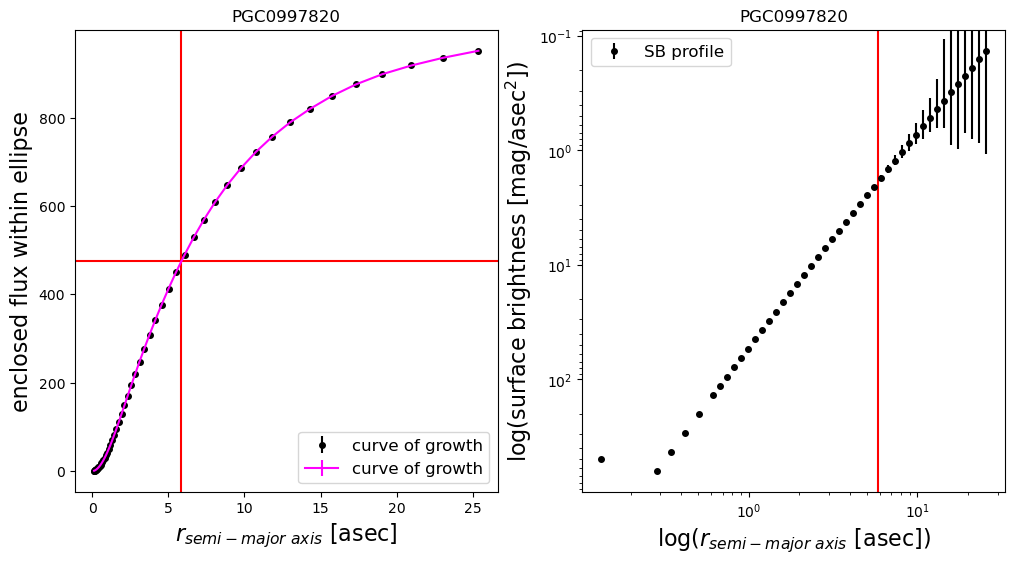

In [90]:
galname = 'PGC0997820'

#***********************
#your code here

mag_zeropoint = header[galname]['MAGZERO']  # magnitude zeropoint
pixel_scale = header[galname]['CD2_2'] * 3600    # in asec/pix
central_radius = np.array([])  # central radius array
surface_brightness = np.array([])  # array of surface brightnesses for each annulus, magnitudes
surface_brightness_error = np.array([])  # array of error on surface brightnesses, magnitudes
total_flux = np.array([])  # flux enclosed within entire ellipse
total_flux_error = np.array([])  # error on total flux

inner_sma = 0.01   # assigns initial inner radius of annulus
# iterates through each ellipse's semi-major axis (sma) starting at the second element
for outer_sma in isolist[galname].sma[1:]:
    # calculates semi-minor axis (smina) given sma and ellipticity
    outer_smina = outer_sma * (1.-epsav[galname])
    inner_smina = inner_sma * (1.-epsav[galname])

    # set up elliptical annulus between each ellipse and its predecessor
    annulus_aperture = EllipticalAnnulus((xcenav[galname],ycenav[galname]), 
                                         inner_sma, outer_sma, outer_smina, b_in = inner_smina,
                                         theta = paav[galname])
    # set up elliptical aperture for each ellipse
    total_aperture = EllipticalAperture((xcenav[galname],ycenav[galname]), 
                                         outer_sma, outer_smina, theta = paav[galname])
    # calculates stats on annulus
    annulus_stats = ApertureStats(data_bsub[galname],annulus_aperture)
    # calculates stats on total aperture
    total_stats = ApertureStats(data_bsub[galname],total_aperture)
    # sets inner_sma equal to current outer_sma for the next iteration
    inner_sma = outer_sma
    
    # the central radius of each annulus in asec. 
    central_radius = np.append(central_radius, ((inner_sma+outer_sma)/2.)*pixel_scale)
    # the average pixel flux within each annulus
    annulus_mean_flux = annulus_stats.mean
    # the standard deviation of the pixel values within each annulus
    annulus_std_flux = annulus_stats.std
    # the number of pixels in each annulus
    annulus_num_pixels = annulus_stats.sum_aper_area

    # total flux for the aperture
    total_flux = np.append(total_flux, total_stats.sum)
    # error on total flux for the aperture
    total_flux_error = np.append(total_flux_error, total_stats.std)
    #****************************
    #your code here
    # asec2 per pixel, removes units 
    pixel_area = pixel_scale ** 2 * u.pix**-2
    # area of annulus in asec2
    annulus_area_asec2 = pixel_area * annulus_num_pixels
    # converts mean flux to instrumental magnitude and then adds zp to get calibrated magnitude
    annulus_mean_magnitude = -2.5 * np.log(annulus_mean_flux) + mag_zeropoint
    # average surface brightness of annulus, in magnitudes per asec2
    annulus_surface_brightness = annulus_mean_magnitude / annulus_area_asec2
    # appends our surface brightness array w/ surface brightness for this annulus
    surface_brightness = np.append(surface_brightness, annulus_surface_brightness)
    # calculates error on annulus magnitude
    annulus_mag_error = annulus_std_flux / (annulus_mean_flux * u.pix)
    # this gets rid of the units on the magnitude error so that the next part works
    annulus_mag_error = annulus_mag_error * u.pix
    surface_brightness_error = np.append(surface_brightness_error, annulus_mag_error)

# initializes figure
fig,ax = plt.subplots(1,2,figsize=(12, 6))
# plot the semi-major axis vs. magnitude
ax[1].errorbar(central_radius, surface_brightness, yerr=surface_brightness_error, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax[1].invert_yaxis()
ax[1].legend(fontsize=12)
ax[1].set_xlabel('log($r_{semi-major~axis}$ [asec])',fontsize=16)
ax[1].set_ylabel('log(surface brightness [mag/asec$^2$])',fontsize=16)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_title(galname)

# plot the curve of growth
ax[0].errorbar(central_radius, total_flux, yerr=total_flux_error, 
             fmt='o', markersize=4, color='black', label='curve of growth')
ax[0].errorbar(central_radius, total_flux, yerr=total_flux_error, 
             fmt='-', markersize=4, color='magenta', label='curve of growth')
ax[0].legend(fontsize=12)
ax[0].set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax[0].set_ylabel('enclosed flux within ellipse',fontsize=16)
ax[0].set_title(galname)

#a horizontal line at half the total flux
ax[0].axhline(total_flux[-1]/2., color='red')
# by eye estimate of what radius on curve cooresponds to half flux
rhalfasec[galname] = 5.85 
# plots the vertical line
ax[0].axvline(rhalfasec[galname], color='red')
# prints estimate
print(f'the half-light radius = {rhalfasec[galname]:.3f} [asec]')

#plot the same line on the surface brightness plot
ax[1].axvline(rhalfasec[galname], color='red', label='$r_{half}$')

# finds radius closest to 3 asecs (estimate of center), finds
# surface brightness at that radius
inner_radius = 3  # asecs
# list of difference between each radius and 3 asecs
distance_to_inner = central_radius - inner_radius
# index of radius with smallest difference to 3 asecs
inner_index = np.argmin(abs(distance_to_inner))
# surface brightness at said radius
inner_surface_brightness = surface_brightness[inner_index]
print(f'surface brightness at center: {inner_surface_brightness:.3f} mag')

# finds the isophote that best corresponds to the half-light radius
# uses the same technique of finding the difference between desired radius
# and the list of central radii, finds the surface brightness at said radius
diff = central_radius - rhalfasec[galname]
rhalfasecind = np.argmin(abs(diff))
half_surface_brightness = surface_brightness[rhalfasecind]
print(f'surface brightness at r half: {half_surface_brightness:.3f} mag')

#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
half_surface_brightness_flux = 10**(-0.4*half_surface_brightness)  # magnitude to maggies
inner_surface_brightness_flux = 10**(-0.4*inner_surface_brightness)  # magnitude to maggies
flux_rat =  half_surface_brightness_flux / inner_surface_brightness_flux  # ratio of both fluxes
print(f'flux_SB(rhalf) / flux_SB(rcent) = {flux_rat:.3f}')

In [47]:
## visible extent
ngc3982_extent_pix = initparams['NGC3982']['sma']
ngc5198_extent_pix = initparams['NGC5198']['sma']
ngc5985_extent_pix = 350
pgc0997820_extent_pix = initparams['PGC0997820']['sma'] 
ngc3982_extent_asec = ngc3982_extent_pix * header['NGC3982']['CD2_2'] * 3600
ngc5198_extent_asec = ngc5198_extent_pix * header['NGC5198']['CD2_2'] * 3600
ngc5985_extent_asec = ngc5985_extent_pix * header['NGC5985']['CD2_2'] * 3600
pgc0997820_extent_asec = pgc0997820_extent_pix * header['PGC0997820']['CD2_2'] * 3600
print(f'ngc3982 extent/half-light: {ngc3982_extent_asec/rhalfasec["NGC3982"]:.3f}')
print(f'ngc5198 extent/half-light: {ngc5198_extent_asec/rhalfasec['NGC5198']:.3f}')
print(f'ngc5985 extent/half-light: {ngc5985_extent_asec/rhalfasec['NGC5985']:.3f}')
print(f'pgc0997820 extent/half-light: {pgc0997820_extent_asec/rhalfasec['PGC0997820']:.3f}')

ngc3982 extent/half-light: 1.661
ngc5198 extent/half-light: 2.079
ngc5985 extent/half-light: 1.638
pgc0997820 extent/half-light: 3.583


In [71]:
pixel_scale = header['NGC3982']['CD2_2']*3600  # asec/pix
print('rhalfasec [pix]:')
for galaxy in rhalfasec:
    print(f'{galaxy}: {rhalfasec[galaxy]/pixel_scale} [pix]')

rhalfasec [pix]:
NGC3982: 69.84732824427479 [pix]
NGC5198: 48.0916030534351 [pix]
NGC5985: 213.7404580152671 [pix]
PGC0997820: 22.328244274809155 [pix]


**Question** For the galaxies above, answer in words written below each bullet:
* For each galaxy how the half-light compares to the visible extent of the galaxy using what you see in the displayed images or in ds9?

    * Visible extent is sma from initial guess from ds9, then converted to asec using the pixel scale. The ratio of the visual extent to the half-light radius is displayed in the output of the code-block above. What we see is that NGC 3982 and NGC 5985 have a ratio of ~ 1.6, NGC 5985 has a ratio of ~ 2. This makes sense since this implies that the half-light radius is roughly half the visual extent. For PGC 0997820, the ratio is ~ 3.6. I imagine this arises largely from my definition of the visual extent.
&nbsp;

* For each galaxy, we need to establish the radius within which nearly all of the flux is contained.  This point can be determined by looking at how the curve of growth changes with radius and is not necessarily the largest radius to which you plot.  which feature of the curve of growth curves you plotted tells you where the radius is that contains most of the flux and whether you can evern robustly determine this radius?

    - I am unsure how to answer this, "most" can mean many things. The half-light radius is the point in which half the flux is contained, and thus any radius larger than half-light will contain a majority of the light. This graph should approach an asymptote if you go to larger and larger sma, and each sma will have some fraction of the "total" flux, it just depends what you find to be "most". To me, the use of the half-light radius makes sense.
&nbsp;


* For each galaxy, use imexam to measure the FWHM of the image using stars in the image.  Then quantify how your half-light radius for each galaxy compares to the FWHM.  Do you think that the half-light radius is big enough to not be influenced by smearing of the image by the PSF.  This needs to be given for each galaxy.

    - NGC 3982
        - FWHM: ~6. Rhalfasec(pix): ~70
        - I don't think the PSF has much of an affect on the half-light radius
    - NGC 5198
        - FWHM:  ~8 Rhalfasec(pix): ~48
        - I don't think the PSF has much of an affect on the half-light radius
    - NGC 5985
        - FWHM:  ~9 Rhalfasec(pix): ~214
        - I don't think the PSF has much of an affect on the half-light radius
    - PGC 0997820
        - FWHM:  ~ 7.2 Rhalfasec(pix): ~22
        - I think the half-light radius could certainly by affected by the PSF of this image, since the FWHM is 1/3 of that of the halflight radius.

**Question** If the goal of measuring the half-light radius is to measure the distribution of light from the galaxy and not any other sources on the image, what do you think you can do in order to minimize the effect of other sources in the image on this measurment.  

**put answer here**\
My only thought would be to mask out other sources, using gaussian fitting you could mask out stars and still use the whole image. I'm not 100% what I'd do nor what the question is, but yea, I think you could use masking to get a better estimate.


## Problem 5 - Describe the ratio in surface brightness between the center and outskirts, as well as the other points below: (10 points)
* Are there differences in the profiles between ellipticals and spirals?
* Does the behavior of the light profile differ inside and outside of the half-light radius?  
* Which galaxies have light profiles consistent with being exponential, and in what part of the profiles? You must describe why they look like exponentials.  Note that not all galaxies have exponential profiles, but some do.
* For the galaxies consistent with an exponential profile, what is exponential scale length of the disk.  You must show all your calculations.

**answer goes here**
I took the liberty of plotting SB on a log-log graph
1. Not really, they are all power laws (exponentials look linear on log-log)
2. Uncertainties get much higher after the half light radius, but they generally still follow the power law 
3. All of these galaxies have power law profiles. On log-log graphs power laws look linear. This is happening, I'd imagine, because of the inverse square law, that light is decaying faster than new sources can compensate.
4. I didn't find any exponential profiles. I wonder if I did something wrong here and should have gotten exponentials
